In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('album.csv', 'album'),
    ('album2.csv', 'album2'),
    ('artist.csv', 'artist'),
    ('customer.csv', 'customer'),
    ('employee.csv', 'employee'),
    ('genre.csv', 'genre'),
    ('invoice.csv', 'invoice'),
    ('invoice_line.csv', 'invoice_line'),
    ('media_type.csv','media_type'),
    ('playlist.csv','playlist'),
    ('playlist_track.csv','playlist_track'),
    ('track.csv','track')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rohit@299',
    database='music_store'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/rohit/OneDrive/Documents/Music/music store data'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing album.csv
NaN values before replacement:
album_id     0
title        0
artist_id    0
dtype: int64

Processing album2.csv
NaN values before replacement:
album_id     0
title        0
artist_id    0
dtype: int64

Processing artist.csv
NaN values before replacement:
artist_id    0
name         0
dtype: int64

Processing customer.csv
NaN values before replacement:
customer_id        0
first_name         0
last_name          0
company           49
address            0
city               0
state             29
country            0
postal_code        4
phone              1
fax               47
email              0
support_rep_id     0
dtype: int64

Processing employee.csv
NaN values before replacement:
employee_id    0
last_name      0
first_name     0
title          0
reports_to     1
levels         0
birthdate      0
hire_date      0
address        0
city           0
state          0
country        0
postal_code    0
phone          0
fax            0
email          0
dtype: int6

In [55]:
#import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Rohit@299',
    database='music_store')

cur = db.cursor()

# SQL PROJECT- MUSIC STORE DATA ANALYSIS

## Question Set 1 - Easy

#### 1. Who is the senior most employee based on job title?


In [13]:
query = """SELECT * FROM employee
           ORDER BY levels DESC
           LIMIT 1 """

cur.execute(query)
data = cur.fetchall()
data                

[(9,
  'Madan',
  'Mohan',
  'Senior General Manager',
  None,
  'L7',
  '26-01-1961 00:00',
  '14-01-2016 00:00',
  '1008 Vrinda Ave MT',
  'Edmonton',
  'AB',
  'Canada',
  'T5K 2N1',
  '+1 (780) 428-9482',
  '+1 (780) 428-3457',
  'madan.mohan@chinookcorp.com')]

In [9]:
#row
for row in data:
    print(row)

(9, 'Madan', 'Mohan', 'Senior General Manager', None, 'L7', '26-01-1961 00:00', '14-01-2016 00:00', '1008 Vrinda Ave MT', 'Edmonton', 'AB', 'Canada', 'T5K 2N1', '+1 (780) 428-9482', '+1 (780) 428-3457', 'madan.mohan@chinookcorp.com')


#### 2. Which countries have the most Invoices?

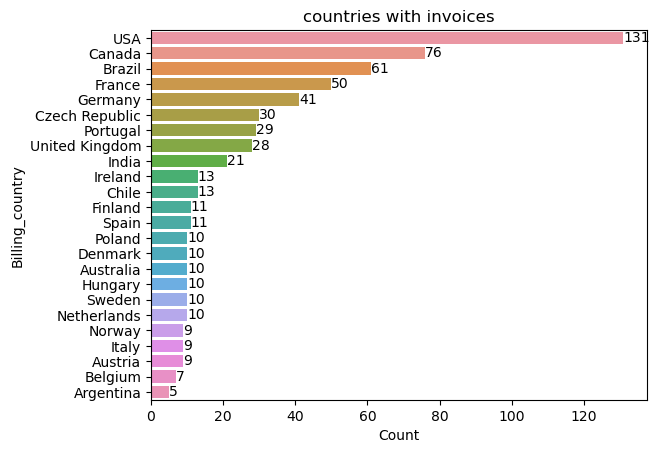

In [24]:
query = """SELECT COUNT(*) AS C, billing_country 
           FROM invoice
           GROUP BY billing_country
           ORDER BY C DESC"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data,columns = ["Count","Billing_country"])
df
ax = sns.barplot(x = df["Count"],y = df["Billing_country"],data = df)
plt.xticks(rotation =0)
ax.bar_label(ax.containers[0])
plt.title("countries with invoices")
plt.show()

#### 3. What are top 3 values of total invoice?

In [35]:
query = """SELECT total FROM invoice
           ORDER BY total DESC
           LIMIT 3"""

cur.execute(query)
data = cur.fetchall()

# Print the fetched data in column format
#for row in data:
    #print(row[0])  # row[0] is used because fetchall() returns a list of tuples

df = pd.DataFrame(data, columns = ["Total"])
df

,Total
0,23.76
1,19.80
2,19.80


#### 4. Which city has the best customers? We would like to throw a promotional Music Festival in the city we made the most money. Write a query that returns one city that has the highest sum of invoice totals. Return both the city name & sum of all invoice totals


In [40]:
query = """SELECT BILLING_CITY, SUM(TOTAL) AS INVOICE_TOTAL FROM  INVOICE
           GROUP BY BILLING_CITY
           ORDER BY INVOICE_TOTAL DESC 
           LIMIT 1"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data,columns = ["Billing_Ciy","Invoice_total"])
df

,Billing_Ciy,Invoice_total
0,Prague,273.24


#### 5. Who is the best customer? The customer who has spent the most money will be declared the best customer. Write a query that returns the person who has spent the most money

In [52]:
query = """SELECT C.CUSTOMER_ID, C.FIRST_NAME, C.LAST_NAME, SUM(INVOICE.TOTAL)AS TOTAL FROM CUSTOMER AS C
            JOIN INVOICE 
            ON C.CUSTOMER_ID = INVOICE.CUSTOMER_ID
            GROUP BY C.CUSTOMER_ID,C.FIRST_NAME, C.LAST_NAME
            ORDER BY TOTAL DESC
            LIMIT 1"""
cur.execute(query)
data = cur.fetchall()
data

[(5, 'František', 'Wichterlová', 144.5399980545044)]

## Question Set 2 – Moderate

#### 1. Write query to return the email, first name, last name, & Genre of all Rock Music listeners. Return your list ordered alphabetically by email starting with A

In [61]:
query = """ SELECT DISTINCT EMAIL, FIRST_NAME, LAST_NAME
            FROM CUSTOMER
            JOIN INVOICE ON CUSTOMER.CUSTOMER_ID = INVOICE.CUSTOMER_ID
            JOIN INVOICE_LINE ON INVOICE.INVOICE_ID = INVOICE_LINE.INVOICE_ID
            WHERE TRACK_ID IN(
              SELECT TRACK_ID FROM TRACK
              JOIN GENRE ON TRACK.GENRE_ID = GENRE.GENRE_ID
              WHERE GENRE.NAME LIKE 'Rock'
              )
            ORDER BY EMAIL; """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns = ["Email","first_name","last_name"])
df

,Email,first_name,last_name
0,aaronmitchell@yahoo.ca,Aaron,Mitchell
1,alero@uol.com.br,Alexandre,Rocha
2,astrid.gruber@apple.at,Astrid,Gruber
3,bjorn.hansen@yahoo.no,Bjørn,Hansen
4,camille.bernard@yahoo.fr,Camille,Bernard
5,daan_peeters@apple.be,Daan,Peeters
6,diego.gutierrez@yahoo.ar,Diego,Gutiérrez
7,dmiller@comcast.com,Dan,Miller
8,dominiquelefebvre@gmail.com,Dominique,Lefebvre
9,edfrancis@yachoo.ca,Edward,Francis


#### 2. Let's invite the artists who have written the most rock music in our dataset. Write a query that returns the Artist name and total track count of the top 10 rock bands


In [66]:
query =  """SELECT COUNT(ARTIST.ARTIST_ID)AS NUMBER_OF_SONGS, ARTIST.NAME
            FROM TRACK
            JOIN ALBUM ON TRACK.ALBUM_ID = TRACK.ALBUM_ID
            JOIN ARTIST ON ARTIST.ARTIST_ID = ALBUM.ALBUM_ID
            JOIN GENRE ON GENRE.GENRE_ID = TRACK.GENRE_ID
            GROUP BY ARTIST.ARTIST_ID, ARTIST.NAME
            ORDER BY NUMBER_OF_SONGS DESC
            LIMIT 10;"""
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data,columns = ["Artist_id","Name"])
df

,Artist_id,Name
0,3503,Accept
1,3503,AC/DC
2,3503,Aerosmith
3,3503,David Coverdale
4,3503,Jack's Mannequin & Mick Fleetwood
5,3503,Chicago Symphony Orchestra & Fritz Reiner
6,3503,Nicolaus Esterhazy Sinfonia
7,3503,Itzhak Perlman
8,3503,Ed Motta
9,3503,Edo de Waart & San Francisco Symphony


#### 3. Return all the track names that have a song length longer than the average song length. Return the Name and Milliseconds for each track. Order by the song length with the longest songs listed first

In [70]:
query = """SELECT NAME, MILLISECONDS
                FROM TRACK
                WHERE MILLISECONDS > (
                     SELECT AVG(MILLISECONDS) AS AVG_TRACK_LENGTH
                	 FROM TRACK)
                ORDER BY MILLISECONDS DESC;"""

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=["Name","milli"])
df

,Name,milli
0,Occupation / Precipice,5286953
1,Through a Looking Glass,5088838
2,"Greetings from Earth, Pt. 1",2960293
3,The Man With Nine Lives,2956998
4,"Battlestar Galactica, Pt. 2",2956081
...,...,...
489,22 Acacia Avenue,395572
490,The Unforgiven II,395520
491,The Shortest Straw,395389
492,"Concerto for Clarinet in A Major, K. 622: II. ...",394482


## Question Set 3 – Advance

#### 1. Find how much amount spent by each customer on artists? Write a query to return customer name, artist name and total spent

In [81]:
query = """WITH BEST_SELLING_ARTIST AS (
            SELECT ARTIST.ARTIST_ID, ARTIST.NAME AS ARTIST_NAME, SUM(INVOICE_LINE.UNIT_PRICE * INVOICE_LINE.QUANTITY) AS TOTAL_SALES
        	FROM INVOICE_LINE
        	JOIN TRACK ON TRACK.TRACK_ID = INVOICE_LINE.TRACK_ID
        	JOIN ALBUM ON ALBUM.ALBUM_ID = TRACK.ALBUM_ID 
        	JOIN ARTIST ON ARTIST.ARTIST_ID = ALBUM.ARTIST_ID
        	GROUP BY ARTIST.ARTIST_ID, ARTIST.NAME
        	ORDER BY TOTAL_SALES DESC
        	LIMIT 1
        )
        SELECT C.CUSTOMER_ID, C.FIRST_NAME, C.LAST_NAME, BSA.ARTIST_NAME,
        SUM(IL.UNIT_PRICE * IL.QUANTITY) AS AMOUNT_SPENT
        FROM INVOICE I
        JOIN CUSTOMER C ON C.CUSTOMER_ID = I.CUSTOMER_ID
        JOIN INVOICE_LINE IL ON IL.INVOICE_ID = I.INVOICE_ID
        JOIN TRACK T ON T.TRACK_ID = IL.TRACK_ID
        JOIN ALBUM ALB ON ALB.ALBUM_ID = T.ALBUM_ID
        JOIN BEST_SELLING_ARTIST BSA ON BSA.ARTIST_ID = ALB.ARTIST_ID
        GROUP BY C.CUSTOMER_ID, C.FIRST_NAME, C.LAST_NAME, BSA.ARTIST_NAME
        ORDER BY AMOUNT_SPENT DESC;
        """

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["Customer_id","first_name","last_name","artist_name","amount_spent"])
df

,Customer_id,first_name,last_name,artist_name,amount_spent
0,46,Hugh,O'Reilly,Queen,27.72
1,38,Niklas,Schröder,Queen,18.81
2,3,François,Tremblay,Queen,17.82
3,34,João,Fernandes,Queen,16.83
4,53,Phil,Hughes,Queen,11.88
5,41,Marc,Dubois,Queen,11.88
6,47,Lucas,Mancini,Queen,10.89
7,33,Ellie,Sullivan,Queen,10.89
8,20,Dan,Miller,Queen,3.96
9,5,František,Wichterlová,Queen,3.96


#### 2. We want to find out the most popular music Genre for each country. We determine the most popular genre as the genre with the highest amount of purchases. Write a query that returns each country along with the top Genre. For countries where the maximum number of purchases is shared return all Genres


In [83]:
query = """WITH POPULAR_GENRE AS 
            (     
                 SELECT COUNT(INVOICE_LINE.QUANTITY)AS PURCHASE, CUSTOMER.COUNTRY, GENRE.NAME,
            	 GENRE.GENRE_ID,
            	 ROW_NUMBER() OVER(PARTITION BY CUSTOMER.COUNTRY ORDER BY COUNT(INVOICE_LINE.QUANTITY)DESC) AS ROWNO
            	 FROM INVOICE_LINE
            	 JOIN INVOICE ON INVOICE.INVOICE_ID = INVOICE_LINE.INVOICE_ID
            	 JOIN CUSTOMER ON CUSTOMER.CUSTOMER_ID = INVOICE.CUSTOMER_ID
            	 JOIN TRACK ON TRACK.TRACK_ID = INVOICE_LINE.TRACK_ID
            	 JOIN GENRE ON GENRE.GENRE_ID = TRACK.GENRE_ID
            	 GROUP BY 2,3,4
            	 ORDER BY 2 ASC, 1 DESC
            	 )
            SELECT * FROM POPULAR_GENRE 
            WHERE ROWNO <=1 """
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=["purchase","country","name","genre_id","rowno"])
df

,purchase,country,name,genre_id,rowno
0,17,Argentina,Alternative & Punk,4,1
1,34,Australia,Rock,1,1
2,40,Austria,Rock,1,1
3,26,Belgium,Rock,1,1
4,205,Brazil,Rock,1,1
5,333,Canada,Rock,1,1
6,61,Chile,Rock,1,1
7,143,Czech Republic,Rock,1,1
8,24,Denmark,Rock,1,1
9,46,Finland,Rock,1,1


#### 3. Write a query that determines the customer that has spent the most on music for each country. Write a query that returns the country along with the top customer and how much they spent. For countries where the top amount spent is shared, provide all customers who spent this amount

In [86]:
query = """WITH RECURSIVE
   CUSTOMER_WITH_COUNTRY AS (
     SELECT CUSTOMER.CUSTOMER_Id, FIRST_NAME, LAST_NAME, BILLING_COUNTRY, 
	 SUM(TOTAL)AS TOTAL_SPENDING
	 FROM INVOICE
	 JOIN CUSTOMER ON CUSTOMER.CUSTOMER_ID = INVOICE.CUSTOMER_ID
	 GROUP BY 1,2,3,4
	 ORDER BY 1,5 DESC),
   COUNTRY_MAX_SPENDING AS(
     SELECT BILLING_COUNTRY, MAX(TOTAL_SPENDING)AS MAX_SPENDING
	 FROM CUSTOMER_WITH_COUNTRY
	 GROUP BY BILLING_COUNTRY)
SELECT CC.BILLING_COUNTRY, CC.TOTAL_SPENDING, CC.FIRST_NAME,CC.LAST_NAME,CC.CUSTOMER_ID
     FROM CUSTOMER_WITH_COUNTRY CC
	 JOIN COUNTRY_MAX_SPENDING MS
	 ON CC.BILLING_COUNTRY = MS.BILLING_COUNTRY
	 WHERE CC.TOTAL_SPENDING = MS.MAX_SPENDING
	 ORDER BY 1;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["billiing_country","total_spending","first_name","last_name","customer_id"])
df

,billiing_country,total_spending,first_name,last_name,customer_id
0,Argentina,39.599999,Diego,Gutiérrez,56
1,Australia,81.180000,Mark,Taylor,55
2,Austria,69.299999,Astrid,Gruber,7
3,Belgium,60.390000,Daan,Peeters,8
4,Brazil,108.899999,Luís,Gonçalves,1
5,Canada,99.989998,François,Tremblay,3
6,Chile,97.020000,Luis,Rojas,57
7,Czech Republic,144.539998,František,Wichterlová,5
8,Denmark,37.620000,Kara,Nielsen,9
9,Finland,79.200001,Terhi,Hämäläinen,44
